In [1]:
import cv2
import math
import numpy as np
import imutils
import subprocess
from IPython.display import Image

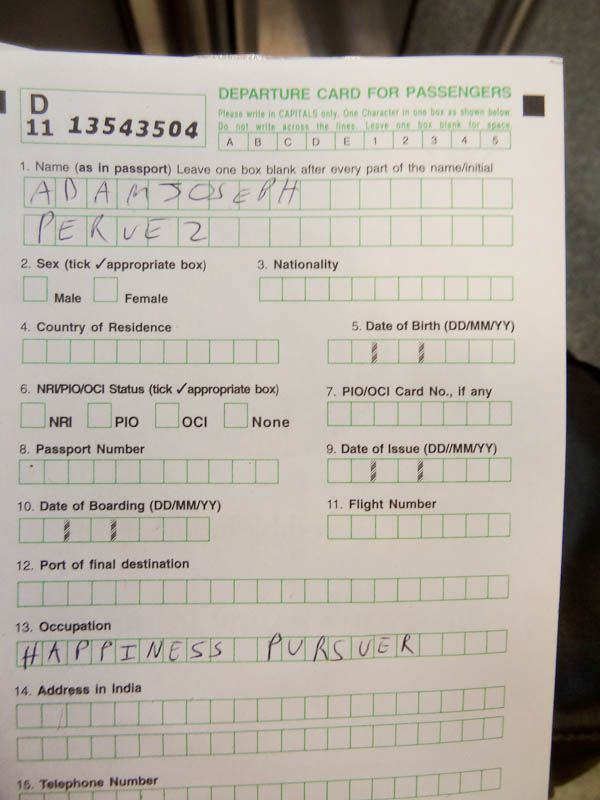

In [2]:
inputFile = "form9.jpg"
Image(filename='../CSharp/ICRExtraction/Samples/' + inputFile)

Width: 600
Height: 800
Width: 600
Height: 800
Num junctions: 6026
Row: 800
Col: 600


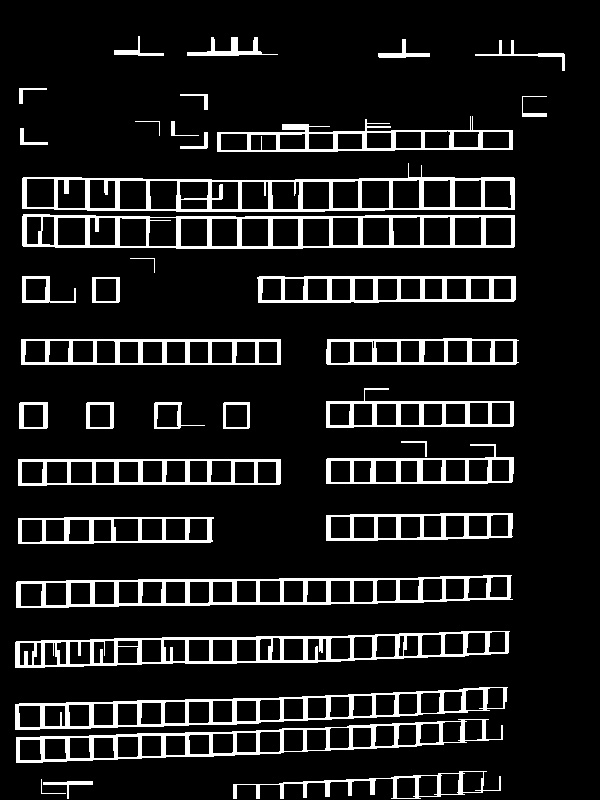

In [3]:
orig = cv2.imread("../CSharp/ICRExtraction/Samples/" + inputFile)

def new(name, data):
    return type(name, (object,), data)

# Options
resize_width = 800
junction_width = 25
junction_height = 15

height, width, _ = orig.shape

print("Width: " + str(width))
print("Height: " + str(height))

if width > resize_width:
    resize_height = int(resize_width * height / width);
    orig = cv2.resize(orig, (resize_width, resize_height))
else:
    resize_height = height

height, width, _ = orig.shape

print("Width: " + str(width))
print("Height: " + str(height))
    
img = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Black and white picture
img = cv2.adaptiveThreshold(img, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 9, 4)

img = cv2.bitwise_not(img)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2, 2))
img = cv2.dilate(img, kernel)
#img = cv2.bitwise_not(img)

row, col = img.shape
new_image = np.zeros(img.shape, dtype = "uint8")

# We are seaching for pattern!
# We look for junctions.
# This will help us make a decision.
# Junction types: T, L, +.
# Junctions allow us to find boxes contours.

# Cache per line speed up the creation of various cache.
cache_list_junction_per_line = {}
list_junction = []

max_proximity = 10

def draw_junction(img, junction):
    top = junction.top
    bottom = junction.bottom
    right = junction.right
    left = junction.left
    num_top = junction.num_top
    num_bottom = junction.num_bottom
    num_right = junction.num_right
    num_left = junction.num_left
    x = junction.x
    y = junction.y
    
    if len(img.shape) == 3:
        # Colors.
        if (top):
            for i in range(num_top):
                img.itemset((y - i, x, 2), 255)
        if (bottom):
            for i in range(num_bottom):
                img.itemset((y + i, x, 2), 255)
        if (right):
            for i in range(num_right):
                img.itemset((y, x + i, 2), 255)
        if (left):
            for i in range(num_left):
                img.itemset((y, x - i, 2), 255)
    else:
        # Black and white.
        if (top):
            for i in range(num_top):
                img.itemset(y - i, x, 255)
        if (bottom):
            for i in range(num_bottom):
                img.itemset(y + i, x, 255)
        if (right):
            for i in range(num_right):
                img.itemset(y, x + i, 255)
        if (left):
            for i in range(num_left):
                img.itemset(y, x - i, 255)


def get_junction(img, row, col, width, height, y, x):
    val = get_val(img, y, x, row, col)
    if 0 < val:
        # Let's explore the directions.
        num_top = 0
        if y - height >= 0:
            for i in range(height):
                if get_val(img, y - i, x, row, col) == val:
                    num_top += 1
                else:
                    break
        num_bottom = 0
        if y + height < row:
            for i in range(height):
                if get_val(img, y + i, x, row, col) == val:
                    num_bottom += 1
                else:
                    break

        num_right = 0
        if x + width < col:
            for i in range(width):
                if get_val(img, y, x + i, row, col) == val:
                    num_right += 1

        num_left = 0
        if x - width >= 0:
            for i in range(width):
                if get_val(img, y, x - i, row, col) == val:
                    num_left += 1
        
        top = num_top >= height
        bottom = num_bottom >= height
        left = num_left >= width
        right = num_right >= width
        
        if (top or bottom) and (left or right):
            return new('Junction', {
                'bottom': bottom,
                'left': left,
                'right': right,
                'top': top,
                'num_bottom': num_bottom,
                'num_left': num_left,
                'num_right': num_right,
                'num_top': num_top,
                'x': x,
                'y': y
            })
    return None

def get_val(img, y, x, row, col):
    if (1 <= x < col - 1) and (1 <= y < row - 1):
        return img.item(y, x) | img.item(y, x - 1) | img.item(y, x + 1)
    else:
        # Outside the image.
        return 0

num_junctions = 0
for y in range(row):
    for x in range(col):
        junction = get_junction(img, row, col, junction_width, junction_height, y, x)
        if junction is not None:
            num_junctions += 1
            draw_junction(new_image, junction)

print("Num junctions: " + str(num_junctions))

print("Row: " + str(row))
print("Col: " + str(col))

#cv2.rectangle(img, (44, 357), (200, 100), (255, 255, 255), -1)

cv2.imwrite("files/result-0.jpg", new_image)
Image(filename='files/result-0.jpg')